# Sampling benchmarks

Performance comparisons for different kinds of weighted random sampling, related to [ChoiceModels PR #37](https://github.com/UDST/choicemodels/pull/37)

Sam Maurer, August 2018 
- updated Sep 2018 to remove old code and add some MergedChoiceTable performance comparisons

In [35]:
import random
import sys
import time
print(sys.version)

3.6.6 | packaged by conda-forge | (default, Jul 26 2018, 09:55:02) 
[GCC 4.2.1 Compatible Apple LLVM 6.1.0 (clang-602.0.53)]


In [32]:
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd

In [27]:
%matplotlib inline

In [3]:
import choicemodels

## Performance comparison - underlying sampling libraries

`random.choices`: replacement, optional weights - Python 3.6 and above  
`random.sample`: no replacement  
`np.random.choice`: optional replacement, optional weights

For each one, draw 100 samples of 10 alternatives from a universe of 100,000

In [74]:
n = int(1e5)
vals = np.random.rand(n)
weights = np.random.rand(n)
scaled_weights = weights/weights.sum(0)  # probs that sum to 1

In [75]:
%%timeit 3
    for i in range(100):
        random.choices(vals, k=10)

343 µs ± 4.87 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [76]:
%%timeit 3
    for i in range(100):
        random.choices(vals, weights, k=10)

796 ms ± 9.55 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [77]:
%%timeit 3
    for i in range(100):
        random.sample(vals.tolist(), k=10)

158 ms ± 925 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [78]:
%%timeit 3
    for i in range(100):
        np.random.choice(vals, replace=True, size=10)

853 µs ± 17.1 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [9]:
%%timeit 3
    for i in range(100):
        np.random.choice(vals, replace=False, size=10)

137 ms ± 370 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [10]:
%%timeit 3
    for i in range(100):
        np.random.choice(vals, replace=True, p=scaled_weights, size=10)

71 ms ± 212 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [11]:
%%timeit 3
    for i in range(100):
        np.random.choice(vals, replace=False, p=scaled_weights, size=10)

79.7 ms ± 260 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


Here are the winners, with times scaled to be relative:

```
1 ms    replacement, core python  
200 ms  replacement with weights, numpy

400 ms  no replacement, numpy
240 ms  no replacement with weights, numpy
```

In [45]:
# What's the real-world hit?

n = int(5e6)
vals = np.random.rand(n)
weights = np.random.rand(n)
scaled_weights = weights/weights.sum(0)  # probs that sum to 1

In [46]:
%%timeit 3
    for i in range(100):
        np.random.choice(vals, replace=False, p=scaled_weights, size=100)

1 loop, best of 3: 5.39 s per loop


So drawing 100k samples of 100 without replacement from a universe of 5 million, with weights, would take 90 minues on a fast iMac

## How do the algorithms scale?

Weighted sampling seems like it might be scaling well, but sampling without replacement not so much. Is this true?

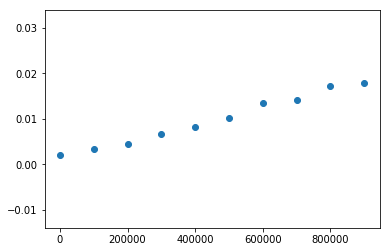

In [39]:
# Uniform with replacement, changing the sample size

scale = np.arange(1e6, step=1e5, dtype=int)
times = []

for n in scale:
    t0 = time.time()
    np.random.choice(np.arange(1e6), size=n)
    times.append(time.time() - t0)
    
plt.scatter(scale, times)

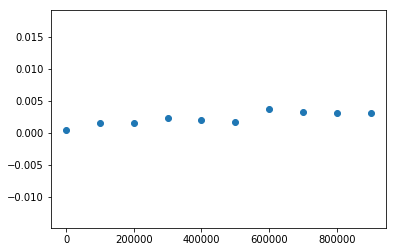

In [46]:
# Uniform with replacement, changing the population size

scale = np.arange(1, 1e6, step=1e5, dtype=int)
times = []

for n in scale:
    t0 = time.time()
    np.random.choice(np.arange(n), size=int(1e5))
    times.append(time.time() - t0)
    
plt.scatter(scale, times)

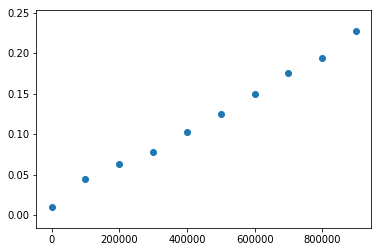

In [49]:
# Weights with replacement, changing the sample size

scale = np.arange(1e6, step=1e5, dtype=int)
times = []

weights = np.random.rand(int(1e6))
w = weights/weights.sum(0)

for n in scale:
    t0 = time.time()
    np.random.choice(np.arange(1e6), size=n, p=w)
    times.append(time.time() - t0)
    
plt.scatter(scale, times)

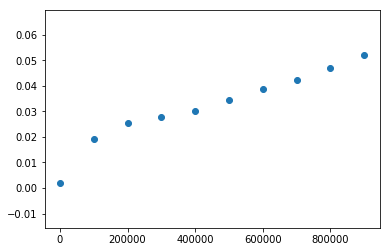

In [53]:
# Weights with replacement, changing the population size

scale = np.arange(1, 1e6, step=1e5, dtype=int)
times = []

for n in scale:
    t0 = time.time()
    weights = np.random.rand(n)
    w = weights/weights.sum(0)
    np.random.choice(np.arange(n), size=int(1e5), p=w)
    times.append(time.time() - t0)
    
plt.scatter(scale, times)

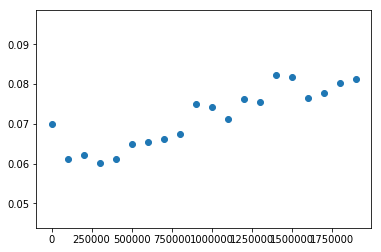

In [65]:
# Uniform without replacement, changing the sample size

scale = np.arange(2e6, step=1e5, dtype=int)
times = []

for n in scale:
    t0 = time.time()
    np.random.choice(np.arange(2e6), size=n, replace=False)
    times.append(time.time() - t0)
    
plt.scatter(scale, times)

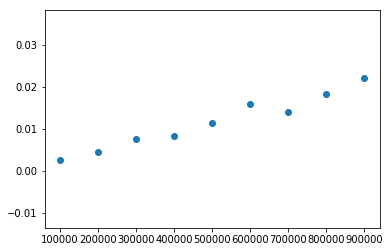

In [55]:
# Uniform without replacement, changing the population size

scale = np.arange(1e5, 1e6, step=1e5, dtype=int)
times = []

for n in scale:
    t0 = time.time()
    np.random.choice(np.arange(n), size=int(1e5), replace=False)
    times.append(time.time() - t0)
    
plt.scatter(scale, times)

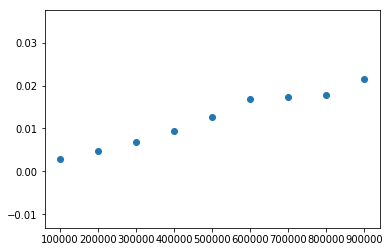

In [59]:
# Uniform without replacement, changing the sample size and population size in proportion

scale = np.arange(1e5, 1e6, step=1e5, dtype=int)
times = []

for n in scale:
    t0 = time.time()
    np.random.choice(np.arange(n), size=int(n/2), replace=False)
    times.append(time.time() - t0)
    
plt.scatter(scale, times)

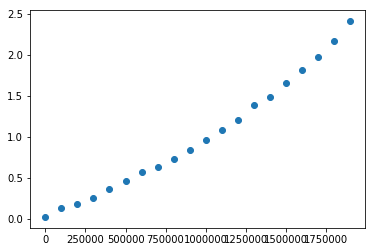

In [81]:
# Weights without replacement, changing the sample size

scale = np.arange(2e6, step=1e5, dtype=int)
times = []

weights = np.random.rand(int(2e6))
w = weights/weights.sum(0)

for n in scale:
    t0 = time.time()
    np.random.choice(np.arange(2e6), size=n, p=w, replace=False)
    times.append(time.time() - t0)
    
plt.scatter(scale, times)

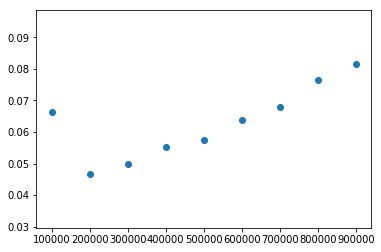

In [70]:
# Weights without replacement, changing the population size

scale = np.arange(1e5, 1e6, step=1e5, dtype=int)
times = []

for n in scale:
    t0 = time.time()
    weights = np.random.rand(n)
    w = weights/weights.sum(0)
    np.random.choice(np.arange(n), size=int(1e5), p=w, replace=False)
    times.append(time.time() - t0)
    
plt.scatter(scale, times)

## Performance comparison - MergedChoiceTable codebase

1000 choosers, 1000 alternatives, combine them in various ways

In [12]:
n = 1000

d1 = {'oid': np.arange(n), 
      'obsval': np.random.random(n),
      'choice': np.random.choice(np.arange(n), size=n)}

d2 = {'aid': np.arange(n), 
      'altval': np.random.random(n),
      'w': np.random.random(n)}

obs = pd.DataFrame(d1).set_index('oid')
alts = pd.DataFrame(d2).set_index('aid')

print(len(obs))
print(obs.head(3))
print(len(alts))
print(alts.head(3))

1000
       obsval  choice
oid                  
0    0.716777     676
1    0.948812      70
2    0.057659     644
1000
       altval         w
aid                    
0    0.183616  0.607503
1    0.206275  0.330906
2    0.970181  0.670955


In [13]:
# build interaction weights - cartesian product of obs and alt ids

w = obs.reset_index()[['oid']].assign(temp=1)\
       .merge(alts.reset_index()[['aid']].assign(temp=1))\
       .drop('temp', axis='columns').set_index(['oid', 'aid'])

w['w'] = np.random.random(n*n)

print(len(w))
print(w.head(3))

1000000
                w
oid aid          
0   0    0.354055
    1    0.800207
    2    0.480832


#### No sampling - 1 million final rows

In [14]:
%%timeit 3
    mct = choicemodels.tools.MergedChoiceTable(obs, alts, sample_size=None)

191 ms ± 31.2 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


#### Random sampling with replacement - 10k final rows

In [15]:
%%timeit 3
    mct = choicemodels.tools.MergedChoiceTable(obs, alts, sample_size=10, replace=True)

4.54 ms ± 1.28 ms per loop (mean ± std. dev. of 7 runs, 100 loops each)


#### Random sampling with replacement - 10k final rows - and merge choice column

In [16]:
%%timeit 3
    mct = choicemodels.tools.MergedChoiceTable(obs, alts, sample_size=10, replace=True,
                                               chosen_alternatives='choice')

6.13 ms ± 38.1 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


#### Random sampling without replacement - 10k final rows

In [17]:
%%timeit 3
    mct = choicemodels.tools.MergedChoiceTable(obs, alts, sample_size=10, replace=False)

268 ms ± 1.31 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


#### Random sampling without replacement - 10k final rows - and merge choice column

In [18]:
%%timeit 3
    mct = choicemodels.tools.MergedChoiceTable(obs, alts, sample_size=10, replace=False,
                                               chosen_alternatives='choice')

296 ms ± 2.52 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


#### Weighted sampling (alt-specific) with replacement - 10k final rows

In [19]:
%%timeit 3
    mct = choicemodels.tools.MergedChoiceTable(obs, alts, sample_size=10, 
                                               replace=True, weights='w')

4.84 ms ± 134 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


#### Weighted sampling (alt-specific) without replacement - 10k final rows

In [20]:
%%timeit 3
    mct = choicemodels.tools.MergedChoiceTable(obs, alts, sample_size=10, 
                                               replace=False, weights='w')

621 ms ± 4.21 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


#### Weighted sampling (interaction) with replacement - 10k final rows

In [21]:
%%timeit 3
    mct = choicemodels.tools.MergedChoiceTable(obs, alts, sample_size=10, 
                                               replace=True, weights=w.w)

894 ms ± 7.08 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


#### Weighted sampling (interaction) without replacement - 10k final rows

In [22]:
%%timeit 3
    mct = choicemodels.tools.MergedChoiceTable(obs, alts, sample_size=10, 
                                               replace=False, weights=w.w)

922 ms ± 4.17 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


## Repeat portions with 1 million agents and alternatives

In [23]:
n = 1000000

d1 = {'oid': np.arange(n), 
      'obsval': np.random.random(n),
      'choice': np.random.choice(np.arange(n), size=n)}

d2 = {'aid': np.arange(n), 
      'altval': np.random.random(n),
      'w': np.random.random(n)}

obs = pd.DataFrame(d1).set_index('oid')
alts = pd.DataFrame(d2).set_index('aid')

print(len(obs))
print(obs.head(3))
print(len(alts))
print(alts.head(3))

1000000
       obsval  choice
oid                  
0    0.482583  650554
1    0.262238  566808
2    0.052340  697805
1000000
       altval         w
aid                    
0    0.451986  0.744388
1    0.977716  0.642022
2    0.046866  0.956607


#### Uniform sampling of 10 with replacement - 10 million final rows

In [24]:
%%timeit
    mct = choicemodels.tools.MergedChoiceTable(obs, alts, sample_size=10, replace=True)

4.35 s ± 47.6 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


#### Compare to earlier urbansim implementation

In [20]:
from urbansim.urbanchoice import interaction

In [22]:
%%timeit
    _ = interaction.mnl_interaction_dataset(obs, alts, 10)

/Users/maurer/anaconda3/envs/template-env/lib/python3.6/site-packages/urbansim-3.1.1-py3.6.egg/urbansim/urbanchoice/interaction.py:83: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  alts_sample['join_index'] = np.repeat(choosers.index.values, SAMPLE_SIZE)


2.64 s ± 199 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


Same order of magnitude (and same underlying sampling algorithm), but new code is a little slower probably because of being more general in how it merges attributes of the observations and alternatives back onto the final table

#### Alt-specific weighted sampling of 10 with replacement - 10 million final rows

In [25]:
%%timeit
    mct = choicemodels.tools.MergedChoiceTable(obs, alts, sample_size=10, 
                                               replace=True, weights='w')

6.85 s ± 105 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


#### Uniform sampling of 10 without replacement - 10 million final rows

In [26]:
%%timeit
    mct = choicemodels.tools.MergedChoiceTable(obs, alts, sample_size=10, 
                                               replace=False)

KeyboardInterrupt: 

## Integrating MCT with estimation

In [18]:
alts = pd.DataFrame(np.random.rand(10,2), columns=['b','c'])

In [19]:
print(len(alts))
alts.head(3)

10


,b,c
0,0.543301,0.507470
1,0.109225,0.223447
2,0.387049,0.036127


In [20]:
n = 100
w = alts.c/alts.c.sum()

obs = pd.DataFrame({'a': np.random.rand(n),
                    'chosen': np.random.choice(range(len(alts)), n, p=w)})

In [21]:
print(len(obs))
obs.head(3)

100


,a,chosen
0,0.138992,5
1,0.174695,7
2,0.135044,6


In [22]:
mct = choicemodels.tools.MergedChoiceTable(obs, alts, 'chosen', sample_size=5, replace=False)

print(len(mct.to_frame()))
mct.to_frame().reset_index().head()

500


,obs_id,alt_id,a,b,c,chosen
0,99,5,0.892908,0.975887,0.929253,1
1,99,4,0.892908,0.241345,0.980643,0
2,99,6,0.892908,0.346340,0.498870,0
3,99,9,0.892908,0.219413,0.777656,0
4,99,8,0.892908,0.562223,0.397979,0


In [23]:
m = choicemodels.MultinomialLogit(mct.to_frame(), 
                                  observation_id_col = mct.observation_id_col,
                                  choice_col = mct.choice_col,
                                  model_expression = 'a + b + c')

m.fit()

                  CHOICEMODELS ESTIMATION RESULTS                  
Dep. Var.:                chosen   No. Observations:            100
Model:         Multinomial Logit   Df Residuals:                 96
Method:       Maximum Likelihood   Df Model:                      4
Date:                 2018-08-20   Pseudo R-squ.:             0.124
Time:                      13:24   Pseudo R-bar-squ.:         0.099
AIC:                     290.005   Log-Likelihood:         -141.002
BIC:                     300.425   LL-Null:                -160.944
               coef   std err         z     P>|z|   Conf. Int.
--------------------------------------------------------------
Intercept   -0.0000     0.469    -0.000     1.000             
a            0.0000     0.418     0.000     1.000             
b            0.3333     0.404     0.824     0.410             
c            2.3596     0.456     5.176     0.000             

https://gist.github.com/smmaurer/c3b4f2f7c4d612a4520de119f9f497cf